In [1]:
import gym
import numpy as np

%matplotlib notebook
from matplotlib import pyplot as plt

from tqdm import tqdm_notebook as tqdm
import copy

from multiprocessing import Pool

In [2]:
class REINFORCE_mc():
    def __init__(self, env, num_episodes=100, alpha_t=2**(-13), alpha_w = 0.001, y=0.9, max_ep_len=1000):
        self.problem = env
        self.num_episodes = num_episodes
        self.y = y
        np.random.seed(1)
        self.theta = np.random.rand(4,2)
        self.w = 0

        self.r = []
        self.s = []
        self.a = []
        self.G = []
        self.alpha_w = alpha_w
        self.alpha_t = alpha_t
        self.max_ep_len = max_ep_len
        self.grad_cache = []
        
        self.I = []
        self.L = []
        
    def get_policy_distribution(self, state):
        z = np.reshape(self.theta.T @ state, (-1,1))
        e = np.exp(z-z.max())
        return (e/e.sum()).T
    
    def sample_from_distribution(self, P):
        CP = np.cumsum(P)
        rn = np.random.uniform()
        
        for i in range(len(CP)):
            if CP[i] >= rn:
                return i
    
    def get_action(self,state):
        return self.sample_from_distribution(self.get_policy_distribution(state)) 
    
    def clear(self):
        self.r = []
        self.s = []
        self.a = []
        self.grad_cache = []
        
    def gen_episode(self, max_len=1000):
        self.clear()
        s0 = self.problem.reset()
        
        state = s0[np.newaxis, :].T
        self.s.append(state)
        
        G = 0
        I = 1
        done = False
        
        while not done and max_len != 0:
            action = self.get_action(state)
            self.a.append(np.argmax(action))
            
            observation, reward, done, _ = self.problem.step(action)
            state = observation[np.newaxis, :].T
            self.s.append(state)
            
            self.r.append(reward)
            G += reward * I
            I *= self.y
            
            max_len -= 1
            
            sof = self.get_policy_distribution(self.s[-2]).T
            grad = (np.diagflat(sof) - sof@sof.T)[:, action]
            grad /= sof[action,0]
            dtheta = self.s[-2] @ grad.reshape((-1,1)).T
            self.grad_cache.append(dtheta)
            
        self.G.append(G)
        
        return G
    
    def mc(self):
        alpha = self.alpha_t
        for i in range(self.num_episodes):
            G = self.gen_episode(self.max_ep_len)
            
            sub = 0
            I = 1
            
            for t in range(len(self.s)-1):
                G -= sub
                    
                # y^t is covered in G in this implementation. G is not strictly G, rather y^t*G
                self.theta = self.theta + alpha*G*self.grad_cache[t]   
                sub = self.r[t]*I
                I *= self.y
                
  

<IPython.core.display.Javascript object>


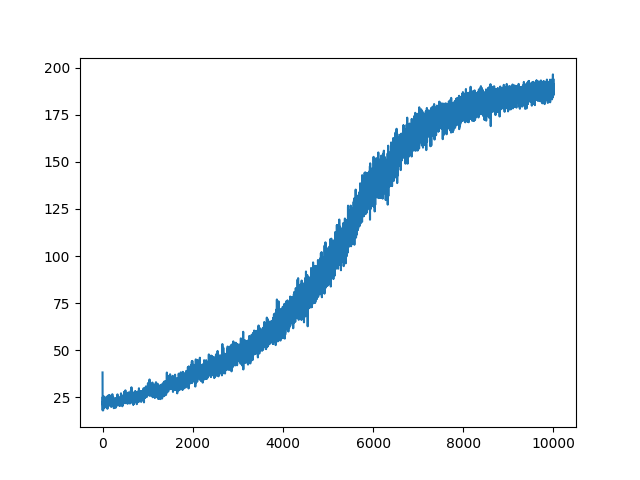

In [3]:
num_ep = 10000
rew = np.zeros((num_ep, 1))
fig = plt.figure()

for i in tqdm(range(100)):
    env = gym.make('CartPole-v0')
    a = REINFORCE_mc(env, num_episodes = num_ep, max_ep_len = -1, alpha_t = 0.00001, y=1)
    a.mc()
    rew += np.array(a.G).reshape((-1,1))
    plt.clf()
    plt.plot(rew/(i+1))
    fig.canvas.draw()

In [6]:
import time
class timer():
    def __init__(self, fps):
        self.fps = fps
        self.prev = time.time()
        
    def tick(self):
        T = time.time()
        if T-self.prev>=1/self.fps:
            self.prev = T
            return True
        return False

In [18]:
t50 = timer(50)
env = gym.make('CartPole-v0')
state = env.reset()[:,np.newaxis]

while True:
    if t50.tick():
        env.render()
        action = a.get_action(state)
        obs,_,_,_ = env.step(action)
        state = obs[:,np.newaxis]
        

KeyboardInterrupt: 

In [15]:
env.close()

In [4]:
from multiprocessing import Pool, Lock

pool = Pool(4)
l = Lock()
num_ep = 100
rew = np.zeros((num_ep, 1))
pbar = tqdm(total=100)
asda = 10

def fun(i=1):
    env = gym.make('CartPole-v0')
#     global rew
#     global pbar
#     global l
    
    a = REINFORCE_mc(env, num_episodes = num_ep, max_ep_len = -1, alpha_t = 0.00001, y=1)
    a.mc()
    l.acquire()
    print(asda)
    rew += np.array(a.G).reshape((-1,1))
    pbar.update(1)
    pbar.refresh()
    l.release()

pool.map(fun, range(100))
pool.close()
pool.join()

Process ForkPoolWorker-14:
Process ForkPoolWorker-15:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Process ForkPoolWorker-16:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self

In [179]:
a = np.array([1,2]).reshape(-1,1)
b = np.array([1,3]).reshape(-1,1)

In [19]:
while 1:
    try:
        l.release()
        print("release")
    except:
        pass

KeyboardInterrupt: 